##  A 4-Hidden Layer Architecture
What is happening here?
    [1] A deep DNN model.
    [2] Import and preprocessing data.
    [3] Trigonometric transformations, which converting the original angle plies into sine and cosine values range between -1 and 1 to helps normalize data.
    [4] Create a neural network model with specific hidden layer and the model uses the Sequential API from Keras, starting with an input layer, followed by a dense (fully connected) hidden layer with ReLU activation, and then an output layer with linear activation (for regression tasks).
    [5] Model Training and Evaluation: run over a range of different number of neurons (from 20 to 80 with step of 15) to tune the model's hyperparameters.
    For each number of neurons: A KerasRegressor wrapper is instantiated with the defined neural network model and training settings (epochs, batch size).
    5-Fold Cross-Validation for robust evaluates the model's performance metrics (MSE, MAE, R-squared) on each fold of the data and to avoid overfitting.
    [6] Model Evaluation (mean and standard deviation of performance metrics).
    [7] Plot Mean of(R2, MAE, RMSE) vs number of neurons.
    [8] After KFold Cross Validation, the dataset is split into training and testing sets. Then, a validation set allows monitoring the model's performance on unseen data during training, which helps in early stopping and preventing overfitting.
    [9] Create a neural network model with specific hidden layer and the model uses the Sequential API from Keras, starting with an input layer, followed by a dense (fully connected) hidden layer with ReLU activation, and then an output layer with linear activation (for regression tasks).
    [10] Plot loss vs the number of epochs & MAE vs the number of epochs
    [11] Plot Correlation between the actual output and the predicted output with the training dataset
    [12] Plot Correlation between the actual output and the predicted output with the testing dataset
    [13] Lastly, SHAP (SHapley Additive exPlanations) values are computed to explain variable importance in the model using shap library. SHAP summary plots (shap.summary_plot) are created to show the impact of different features on the model predictions.

# From the best model in 4-hidden layer

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.base import TransformerMixin
import math
import seaborn as sns
import pandas as pd 
import numpy as np                                             
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from matplotlib import pyplot as plt

## Import data
bucklingdata = pd.read_csv("CBL_SimulationResults.csv", encoding='cp1252')

## Convert the hole_column from integer into a floating data type
bucklingdata['Number of holes, nh'] = bucklingdata['Number of holes, nh'].astype('float64')
bucklingdata['Web opening diameter, Do (mm)'] = bucklingdata['Web opening diameter, Do (mm)'].astype('float64')

## Trigonometric transformation of the ply angles: We develop a trigonometric transformation function to convert the angles (this is important)
# Create a transformation class here for the angle plies:
class TrigonometricTransformer(TransformerMixin):
    def __init__(self, start_column=1, end_column=-1):
        self.start_column = start_column
        self.end_column = end_column
        self.transform_functions = [np.sin, np.cos]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        columns_to_transform = X.columns[self.start_column:self.end_column]

        for col in columns_to_transform:
            for func in self.transform_functions:
                X_transformed[col + '_' + func.__name__] = func(X[col])

        # Remove the original columns
        X_transformed.drop(columns=columns_to_transform, inplace=True)

        return X_transformed

# Specify the input and output datasets
input_data = bucklingdata.drop(['Critical Buckling Load (N)','Critical Buckling Load (kN)'], axis=1)
output_data = bucklingdata['Critical Buckling Load (kN)']

# Apply the transformation on the ply columns
transformer = TrigonometricTransformer(start_column=3, end_column=11)
# Transform the input DataFrame
transformed_bucklingdata = transformer.fit_transform(input_data)

# The input dimension for the Neural Network is then obtained as. Then, the input_size will use in following: model.add(Input(shape=(19,)))
input_size = transformed_bucklingdata.shape[1]
#print(input_size)

## Define a specific neural network model with four hidden layer
def create_model4H(neurons_list):
    model = Sequential()
    model.add(Input(shape=(19,)))
    hp_activation = 'relu'
    model.add(Dense(neurons_list[0], activation=hp_activation))
    model.add(Dense(neurons_list[1], activation=hp_activation))
    model.add(Dense(neurons_list[2], activation=hp_activation))
    model.add(Dense(neurons_list[3], activation=hp_activation))
    model.add(Dense(1, activation='linear'))
    hp_learning_rate = 0.01
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=['mae'])
    return model

## Data splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(transformed_bucklingdata, output_data,
                                                   test_size=0.3,
                                                    stratify=None,
                                                    random_state=42)

# For validation number input and output data
val_no = round(0.2*y_train.size)
x_val = X_train[:val_no]
y_val = y_train[:val_no]

# Specify the number of neurons for the one hidden layers
p1 = 80
p2 = 50
p3 = 35
p4 = 65

#p1 = 20
#p2 = 20
#p3 = 50
#p4 = 35

#p1 = 20
#p2 = 65
#p3 = 50
#p4 = 50

#p1 = 35
#p2 = 80
#p3 = 65
#p4 = 20

#p1 = 20
#p2 = 50
#p3 = 80
#p4 = 35


model = create_model4H([p1, p2, p3, p4])

## Train your model for a number of epochs, with the .fit()
history = model.fit(X_train, y_train, epochs=150,
                    validation_data=(x_val, y_val),batch_size = 32,
                    verbose = 0)

## Get the performance metrics for the network and the learning curves
# Evaluating the model
trainmse, trainmae = model.evaluate(X_train, y_train, verbose=0)
valmse, valmae = model.evaluate(x_val, y_val, verbose=0)
testmse, testmae = model.evaluate(X_test, y_test, verbose=0)

# Capture the Rsquare data: training
train_pred = model.predict(X_train)
train_r2= r2_score(y_train, train_pred)

# Capture the Rsquare data: validation
val_pred = model.predict(x_val)
val_r2= r2_score(y_val, val_pred)

# Capture the Rsquare data: testing
test_pred = model.predict(X_test)
test_r2= r2_score(y_test, test_pred)

rsquares = pd.DataFrame(data = np.column_stack((train_r2, val_r2, test_r2)))
RMSEs = pd.DataFrame(data = np.column_stack((math.sqrt(trainmse), math.sqrt(valmse), math.sqrt(testmse))))
MAEs = pd.DataFrame(data = np.column_stack((trainmae, valmae, testmae)))

print(rsquares)
print(RMSEs)
print(MAEs)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
          0         1         2
0  0.991076  0.993568  0.986834
          0         1         2
0  0.236117  0.206361  0.255976
          0         1         2
0  0.179826  0.157185  0.199322


## loss vs the number of epochs & MAE vs the number of epochs

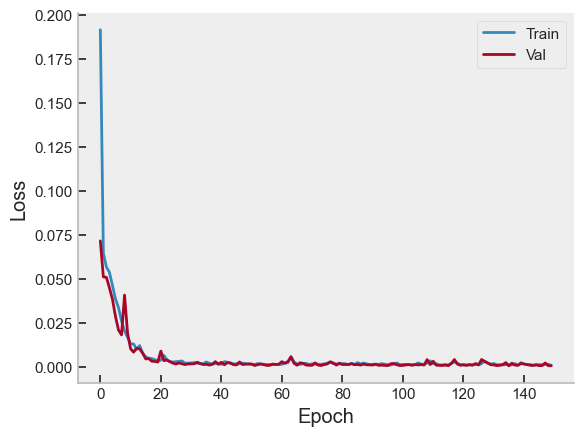

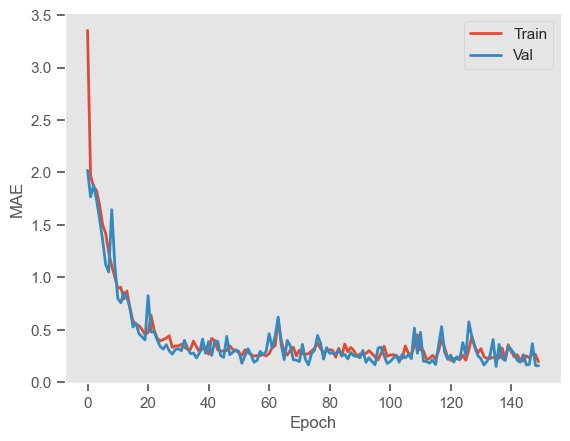

In [13]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.style.use('bmh')
  plt.grid(False)
  plt.plot(loss, linewidth=2)
  plt.plot(val_loss, linewidth=2)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

def plot_mae(mae,val_mae):
  plt.figure()
  plt.style.use('ggplot')
  plt.grid(False)
  plt.plot(mae, linewidth=2)
  plt.plot(val_mae, linewidth=2)
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

train_loss = (np.array(history.history["loss"]))/100
val_loss = np.array((history.history["val_loss"]))/100

plot_loss(train_loss, val_loss)
plot_mae(history.history["mae"], history.history["val_mae"])

### Correlation between the actual output and the predicted output with the training dataset

[]

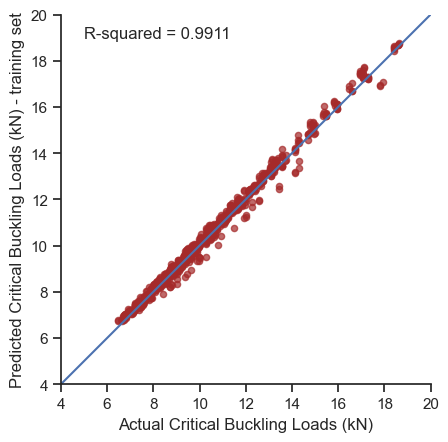

In [14]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
a = plt.axes(aspect='equal')
plt.scatter(y_train, train_pred, s = 20, alpha=0.7, c = 'brown')
plt.xlabel('Actual Critical Buckling Loads (kN)')
plt.ylabel('Predicted Critical Buckling Loads (kN) - training set')
plt.annotate("R-squared = {:.4f}".format(r2_score(y_train, train_pred)), (5, 19))
plt.xlim([4, 20])
plt.ylim([4, 20])
plt.plot([4, 20], [4, 20])
plt.plot()

### Correlation between the actual output and the predicted output with the testing dataset

[]

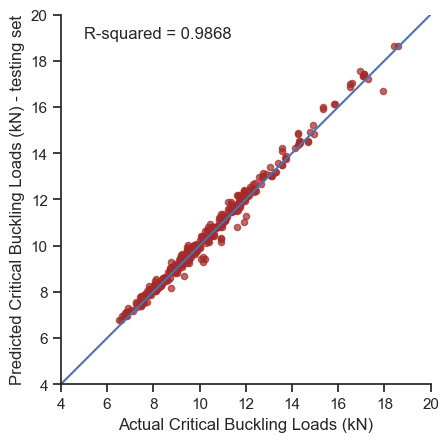

In [15]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_pred, s = 20, alpha=0.7, c = 'brown')
plt.xlabel('Actual Critical Buckling Loads (kN)')
plt.ylabel('Predicted Critical Buckling Loads (kN) - testing set')
plt.annotate("R-squared = {:.4f}".format(r2_score(y_test, test_pred)), (5, 19))
plt.xlim([4, 20])
plt.ylim([4, 20])
plt.plot([4, 20], [4, 20])
plt.plot()

## Variable importance SHAP plot

In [16]:
import shap
### VARIABLE IMPORTANCE
# See more here: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/bar.html
features = ["Number of holes, nh", "Web-post width, WP (mm)",  "Web opening diameter, Do (mm)","Ply 1 (ø)","Ply 1 (ø)", "Ply 2 (ø)", "Ply 2 (ø)","Ply 3 (ø)","Ply 3 (ø)", "Ply 4 (ø)","Ply 4 (ø)", "Ply 5 (ø)", "Ply 5 (ø)","Ply 6 (ø)", "Ply 6 (ø)","Ply 7 (ø)", "Ply 7 (ø)","Ply 8 (ø)","Ply 8 (ø)"]
#features = ["Number of holes, nh", "Web-post width, WP (mm)",  "Web opening diameter, Do (mm)","Ply 1 (ø)_sin", "Ply 1 (ø)_cos", "Ply 2 (ø)_sin", "Ply 2 (ø)_cos", "Ply 3 (ø)_sin", "Ply 3 (ø)_cos", "Ply 4 (ø)_sin", "Ply 4 (ø)_cos","Ply 5 (ø)_sin", "Ply 5 (ø)_cos", "Ply 6 (ø)_sin", "Ply 6 (ø)_cos", "Ply 7 (ø)_sin", "Ply 7 (ø)_cos", "Ply 8 (ø)_sin", "Ply 8 (ø)_cos"]

# Create a SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model, shap.sample(X_train, 100))

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Reshape shap_values to remove the last dimension
shap_values_reshaped = shap_values.reshape(X_test.shape)  # Assuming X_test.shape is (389, 11)

  0%|          | 0/389 [00:00<?, ?it/s]

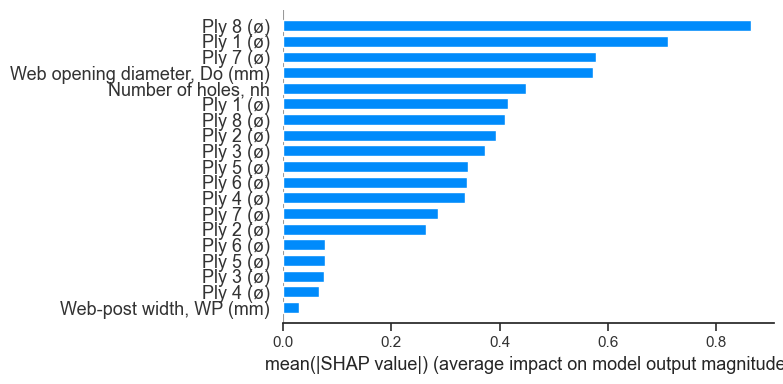

In [17]:
shap.summary_plot(shap_values_reshaped, X_test, feature_names=features, plot_type="bar",plot_size=(8,4))
plt.show()

## Distribution density between the training and testing dataset at 70-30 split. 

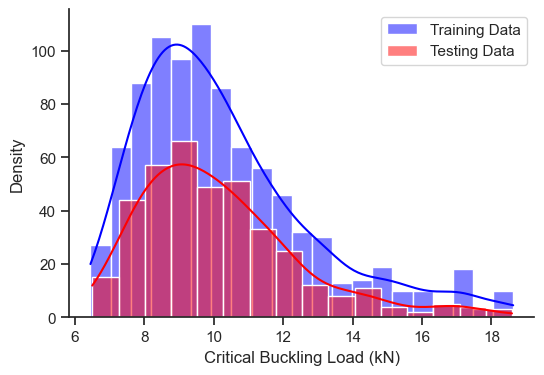

In [22]:
y_train_values = y_train.values.flatten()  # Convert to 1D array
y_test_values = y_test.values.flatten()    # Convert to 1D array

plt.figure(figsize=(6, 4))

# Plot histogram for training data
sns.histplot(y_train_values, kde=True, color='blue', label='Training Data')

# Plot histogram for testing data
sns.histplot(y_test_values, kde=True, color='red', label='Testing Data')

# Add labels and title
plt.xlabel('Critical Buckling Load (kN)')
plt.ylabel('Density')
#plt.title('Distribution of Critical Buckling Load between Training and Testing Data')
plt.legend()
plt.show()

## Variation of the learning curves with the choice of the activation function for the top performing 4-hidden-layer DNN (11-80-50-35-65-1)

In [23]:
def create_model4H(neurons_list, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(19,)))
    model.add(Dense(neurons_list[0], activation=activation))
    model.add(Dense(neurons_list[1], activation=activation))
    model.add(Dense(neurons_list[2], activation=activation))
    model.add(Dense(neurons_list[3], activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.01),
                  metrics=['mae'])
    return model
# Define activation functions to compare
activation_functions = ['relu', 'selu', 'sigmoid', 'tanh']

# Lists to store training histories
histories = []

# Train models with different activation functions
for activation in activation_functions:
    print(f"Training model with activation: {activation}")
    model = create_model4H([80, 50, 35, 65], activation=activation)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=150,
                        validation_data=(x_val, y_val), batch_size=32,
                        verbose=0)
    
    # Store training history
    histories.append((activation, history))

Training model with activation: relu
Training model with activation: selu
Training model with activation: sigmoid
Training model with activation: tanh


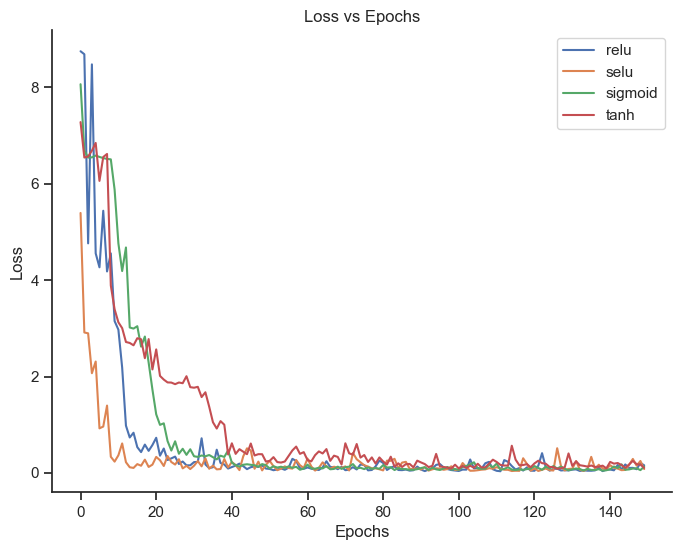

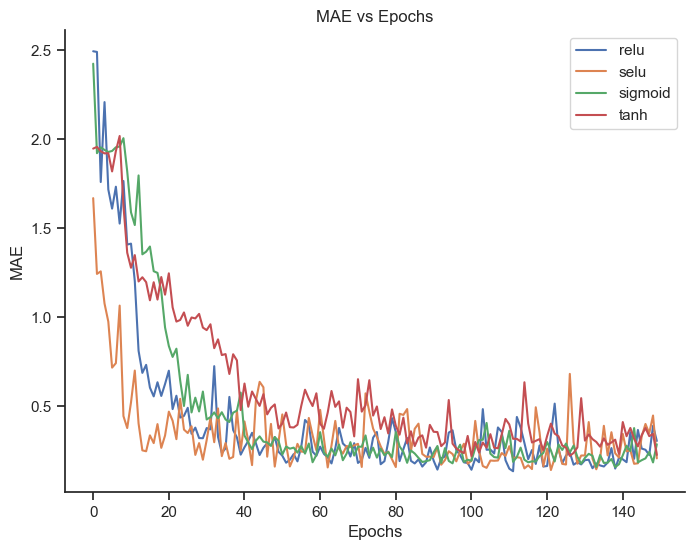

In [24]:
# Plot loss and MAE for each activation function
plt.figure(figsize=(8, 6), facecolor='white')
for activation, history in histories:
    #plt.plot(history.history['loss'], label=f'{activation} - Loss', linestyle='--')
    plt.plot(history.history['val_loss'], label=f'{activation}')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6), facecolor='white')
for activation, history in histories:
    #plt.plot(history.history['mae'], label=f'{activation} - MAE', linestyle='--')
    plt.plot(history.history['val_mae'], label=f'{activation}')
plt.title('MAE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

##  Effect of using different optimizer 

In [27]:
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from sklearn.metrics import mean_absolute_error

# Define the model creation function with customizable activation and optimizer
def create_model4H(neurons_list, activation='relu', optimizer=Adam()):
    model = Sequential()
    model.add(Input(shape=(19,)))
    model.add(Dense(neurons_list[0], activation=activation))
    model.add(Dense(neurons_list[1], activation=activation))
    model.add(Dense(neurons_list[2], activation=activation))
    model.add(Dense(neurons_list[3], activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

# Function to train and evaluate models with different configurations
def train_and_evaluate(X_train, y_train, X_test, y_test, neurons, activation, optimizer_name):
    # Define the optimizer based on name
    if optimizer_name == 'Adam':
        optimizer = Adam()
    elif optimizer_name == 'Adamax':
        optimizer = Adamax()
    elif optimizer_name == 'Nadam':
        optimizer = Nadam()
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop()
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    
    # Split the training set into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Create and compile the model
    model = create_model4H(neurons_list=neurons, activation=activation, optimizer=optimizer)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0, validation_data=(X_val, y_val))
    
    # Evaluate on training, validation, and testing data
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    train_mae = mean_absolute_error(y_train, train_pred)
    val_mae = mean_absolute_error(y_val, val_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    
    return train_r2, val_r2, test_r2, train_mae, val_mae, test_mae

# Define the data splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(transformed_bucklingdata, output_data,
                                                    test_size=0.3, random_state=42)

# Define the model parameters
neurons = [80, 50, 35, 65]
activation = 'relu'
optimizers = ['Adam', 'Adamax', 'Nadam', 'RMSprop']

# Dictionary to collect results
results = {'Optimizer': [], 'Train R2': [], 'Validation R2': [], 'Test R2': [],
           'Train MAE': [], 'Validation MAE': [], 'Test MAE': []}

# Iterate over optimizers and evaluate models
for optimizer in optimizers:
    train_r2, val_r2, test_r2, train_mae, val_mae, test_mae = train_and_evaluate(X_train, y_train, X_test, y_test, neurons, activation, optimizer)
    results['Optimizer'].append(optimizer)
    results['Train R2'].append(train_r2)
    results['Validation R2'].append(val_r2)
    results['Test R2'].append(test_r2)
    results['Train MAE'].append(train_mae)
    results['Validation MAE'].append(val_mae)
    results['Test MAE'].append(test_mae)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
  Optimizer  Train R2  Validation R2   Test R2  Train MAE  Validation MAE  \
0      Adam  0.975277       0.978083  0.967306   0.303576        0.304406   
1    Adamax  0.961967       0.958858  0.951491   0.379195        0.429882   
2     Nadam  0.928872       0.943784  0.921498   0.581220        0.526231   
3   RMSprop  0.614281       0.622726  0.501091   1.381174        1.462374   

   Test MAE  
0  0.319972  
1  0.402728  
2  0.555329  
3  1.452453  
